2440021376 - Denzel Caesarian Iswanto Suhardjo - LA01 - Computer Vision (COMP7116001) - Assignment 4

Seperti biasanya, untuk dapat melakukan proses corner detection dengan menggunakan metode Harris, kita memerlukan beberapa library. Untuk itu, saya memanggil beberapa Library yang akan saya gunakan yaitu cv2 untuk melakukan Image Processing, numpy yang dialiaskan sebagai np untuk membantu beberapa operasi seperti pembuatan array maupun perhitungan, dan matplotlib.pyplot yang dialiaskan sebagai plt untuk memvisualisasikan gambar.

Langkah awal untuk melakukan proses Harris Corner Detection adalah membaca gambar dari folder. Untuk dapat membaca sebuah gambar, saya menggunakan 'cv2.imread' yang diikuti dengan sebuah parameter berupa direktori file gambarnya. Setelah gambar berhasil dibaca, gambar akan disimpan ke dalam variabel image, lalu akan di-convert warnanya menjadi RGB dan Grayscale. 

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread('image.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [2]:
print(grayImage.shape)

(1200, 1200)


Dikarenakan gambar yang saya miliki berukuran cukup besar, maka saya akan mengecilkan resolusi gambarnya agar proses corner detection menjadi lebih efektif. Di sini, saya akan mengecilkan gambar hingga mencapai 30% dari ukuran semula. Proses resizing gambar ini dapat dilakukan dengan bantuan 'cv2.resize' yang diikuti dengan tiga parameter yaitu gambar yang akan diubah resolusinya, dimensi resolusi yang baru, dan interpolasinya.

In [3]:
scale = 30
imageWidth = int(grayImage.shape[0] * scale / 100)
imageHeight = int(grayImage.shape[1] * scale / 100)

dimension = (imageWidth, imageHeight)

resizedImage = cv2.resize(grayImage, dimension, interpolation = cv2.INTER_AREA)

Setelah gambar diperkecil, selanjutnya saya akan memulai proses corner detection dengan mengaplikasikan gaussian blur pada gambar dengan kernel berukuran 5x5. Namun, dikarenakan fungsi 'GaussianBlur' pada library cv2 tidak dapat menerima gambar dengan tipe data integer dan hanya dapat menerima tipe daya float, maka saya mengubah tipe data pada gambar terlebih dahulu dengan bantuan numpy.

In [4]:
resizedImage = np.float32(resizedImage)
blurImage = cv2.GaussianBlur(resizedImage, (5, 5), 0)

Setelah mengaplikasikan gaussian blur pada gambar, langkah selanjutnya adalah melakukan penghitungan gradien. Proses penghitungan gradien ini saya lakukan dengan bantuan metode sobel. Di dalam fungsi 'gradientImage', pertama-tama saya mendeklarasikan matrix gradien X dan matrix gradien Y. Setelah itu, masing-masing dari matrix ini akan dikonvolusikan ke gambar dengan bantuan library scipy dan fungsi 'ndimage.filters.convolve'. Hasil konvolusi akan disimpan pada variabel gradXImage dan gradYImage. 

Setelah nilai gradXImage dan gradYImage didapatkan, selanjutnya saya menghitung nilai gradien dengan cara membagi nilai gradXImage dan gradYImage dengan nilai maksimal dari masing-masingnya. Hasil perhitungan tersebut yang selanjutnya akan dikembalikan ke fungsi utama. Dengan demikian, didapatkan nilai gradX dan gradY setelah melalui proses perhitungan.

In [5]:
import scipy.ndimage as sn

def gradientImage(image):
    gradX = np.array([[-1, 0, 1],
                      [-2, 0, 2],
                      [-1, 0, 1]])
    gradY = np.array([[-1, -2, -1],
                      [0, 0, 0],
                      [1, 2, 1]])

    gradXImage = sn.filters.convolve(image, gradX)
    gradYImage = sn.filters.convolve(image, gradY)

    gradXImage = gradXImage / np.max(gradXImage)
    gradYImage = gradYImage / np.max(gradYImage)

    return gradXImage, gradYImage

gradX, gradY = gradientImage(blurImage)

Selanjutnya, nilai gradX dan gradY ini akan dikuadratkan dan juga dikalikan atau cross product.

In [6]:
gradXX = np.square(gradX)
gradYY = np.square(gradY)
gradXY = gradX * gradY

Ketiga hasil perhitungan yang sudah didapatkan, yaitu gradXX, gradYY, dan gradXY, inilah yang akan digunakan untuk melakukan proses corner detection. Di sini, saya menggunakan konstanta sebesar 0.04 dan ukuran window atau block kernel sebesar 3x3. Proses corner detection akan dilakukan secara menyeluruh pada gambar sehingga diperlukan proses looping sebesar luas gambar dikurangi dengan setengah dari ukuran window atau blocknya. 

Ketika window atau block ini berjalan ke tiap pikselnya, akan dilakukan proses summation pada piksel-piksel yang berada di jangkauan window atau block. Hasil summation ini akan disimpan ke dalam tiga variabel yaitu sXX, sYY, dan sXY. Ketika ketiga nilai tersebut sudah didapatkan, selanjutnya saya menghitung nilai determinan dan trace terlebih dahulu untuk dapat mengetahui nilai response dari piksel tersebut. Determinan dapat dihitung dengan cara mengurangkan hasil kali sXX dan SYY dengan hasil kuadrat dari sXY. Sementara trace dapat dihitung dengan cara menjumlahkan nilai sXX dan sYY. Jika kedua nilai ini sudah dihitung, barulah dapat dilakukan proses perhitungan response dengan cara mengurangkan nilai determinan dengan hasil kali dari k dengan hasil kuadrat dari nilai trace. 

Di dalam proses ini juga, nilai response tertinggi akan disimpan ke dalam sebuah variabel yang bernama max. Nantinya, nilai max ini akan dikalikan dengan angka persentase yang sudah saya tentukan sebagai batas dari threshold. Di sini, saya menggunakan 0.01 sebagai angka persentase yang mengindikasikan bahwa titik-titik koordinat yang diambil hanya yang berada di atas 1% dari nilai maksimalnya.

In [7]:
k = 0.04
window = 3
width, height = blurImage.shape

offset = int(window / 2)
rangeX = width - offset
rangeY = height - offset

max = 0
tuple = []

for i in range (offset, rangeX):
    for j in range (offset, rangeY):
        sXX = np.sum(gradXX[i - offset : i + offset + 1, j - offset : j + offset + 1])
        sYY = np.sum(gradYY[i - offset : i + offset + 1, j - offset : j + offset + 1])
        sXY = np.sum(gradXY[i - offset : i + offset + 1, j - offset : j + offset + 1])

        determinant = (sXX * sYY) - np.square(sXY)
        trace = sXX + sYY

        response = determinant - k * (np.square(trace))

        tuple.append((i, j, response))
        if response > max:
            max = response

corner = []
threshold = 0.01 * max
for data in tuple:
    i, j, response = data
    if response > threshold:
        corner.append([i, j, response])

Proses corner detection sebenarnya sudah selesai sampai disini. Namun, apabila proses terhenti disini, hasil yang didapatkan kurang maksimal karena ukuran titik-titik koordinatnya berbeda-beda. Untuk itu, perlu diberikan satu proses terakhir yaitu non-maximum suppression. Di sini, saya menggunakan 10 sebagai nilai maksimal untuk jaraknya.

In [8]:
distance = 10
finalCorner, xCorner, yCorner = [], [], []

sortedCorner = sorted(corner, key = lambda x: x[2], reverse = True)
finalCorner.append(sortedCorner[0][:-1])

for i in sortedCorner:
    for j in finalCorner:
        if abs(i[0] - j[0]) <= distance and abs(i[1] - j[1]) <= distance:
            break
    else:
        finalCorner.append(i[:-1])
        xCorner.append(i[1])
        yCorner.append(i[0])

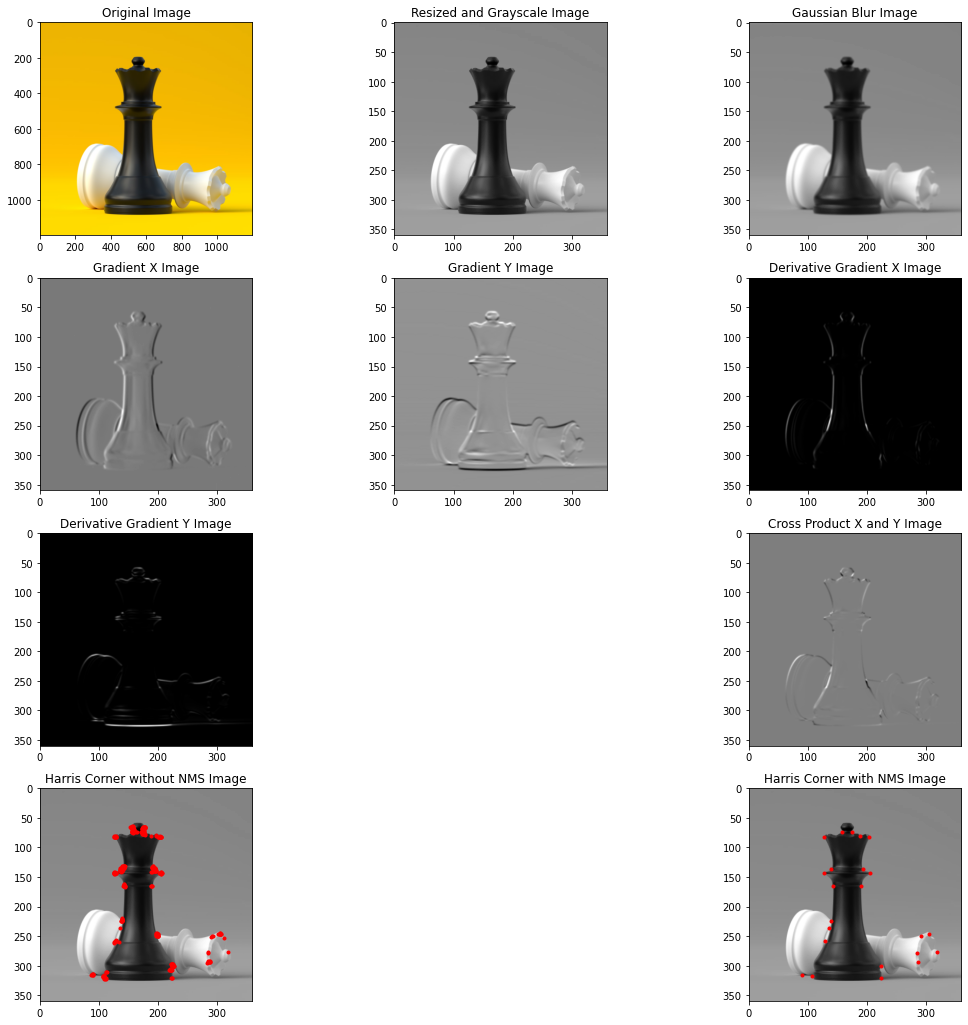

In [17]:
plt.figure(figsize = (18, 18))

plt.subplot(431)
plt.imshow(image)
plt.title("Original Image")

plt.subplot(432)
plt.imshow(resizedImage, cmap = 'gray')
plt.title("Resized and Grayscale Image")

plt.subplot(433)
plt.imshow(blurImage, cmap = 'gray')
plt.title("Gaussian Blur Image")

plt.subplot(434)
plt.imshow(gradX, cmap = 'gray')
plt.title("Gradient X Image")

plt.subplot(435)
plt.imshow(gradY, cmap = 'gray')
plt.title("Gradient Y Image")

plt.subplot(436)
plt.imshow(gradXX, cmap = 'gray')
plt.title("Derivative Gradient X Image")

plt.subplot(437)
plt.imshow(gradYY, cmap = 'gray')
plt.title("Derivative Gradient Y Image")

plt.subplot(439)
plt.imshow(gradXY, cmap = 'gray')
plt.title("Cross Product X and Y Image")

plt.subplot(4, 3, 10)
plt.imshow(resizedImage, cmap = 'gray')
plt.title("Harris Corner without NMS Image")
for i in range (0, len(corner)):
    plt.plot(corner[i][1], corner[i][0], '.', color = 'red')

plt.subplot(4, 3, 12)
plt.imshow(resizedImage, cmap = 'gray')
plt.plot(xCorner, yCorner, '.', color = 'red')
plt.title("Harris Corner with NMS Image")

plt.show()